In [19]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import setGPU
from importlib import reload
import mplhep as hep

import data.data_reader as dare
import data.preprocessing as prep
import data.graph_construction as grctr
import models.graph_nn as grap
import analysis.plotting as plott

In [4]:
%load_ext autoreload
%autoreload 2

# read in data

In [5]:
input_dir = '/eos/cms/store/group/ml/AnomalyHackathon/VAE/samples/v1/qcd/merged/'
file_name = 'flat_scouting_2_numEvent500_event.h5'
file_path = os.path.join(input_dir, file_name)

In [6]:
samples = dare.read_event_samples_from_file(file_path)

In [7]:
samples = samples[:2000]

In [8]:
samples.shape

(2000, 52, 6)

In [9]:
features_names = ['px', 'py', 'pz', 'pt', 'eta', 'phi']

In [11]:
# mask events with ojects having pt > 13000
reload(prep)
pt_idx = features_names.index('pt')
pz_idx = features_names.index('pz')
samples = prep.mask_events_outliers(samples, [pt_idx, pz_idx], [5e3, 5e3])

In [12]:
samples.shape

(2000, 52, 6)

## normalize

In [14]:
reload(prep)
samples = prep.normalize_features(samples)

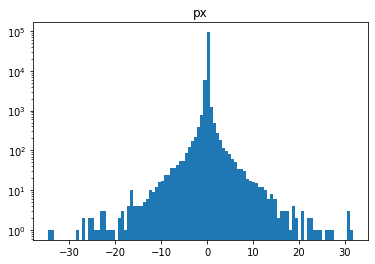

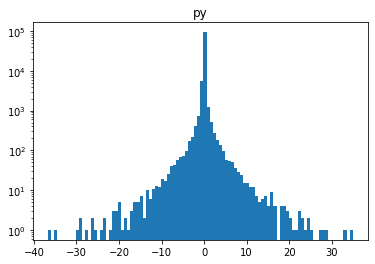

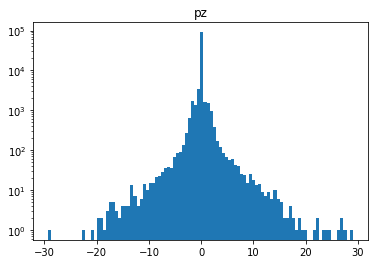

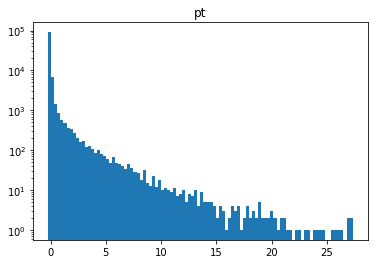

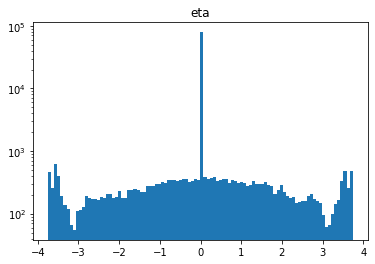

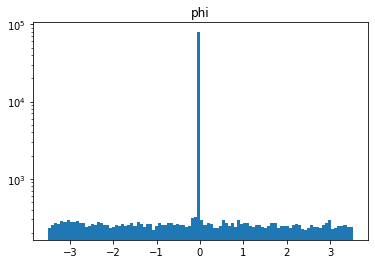

In [15]:
for i in range(samples.shape[2]):
    plt.figure()
    _ = plt.hist(samples[:,:,i].flatten(), bins=100)
    plt.title(features_names[i])
    plt.yscale('log')

# prepare input for model

In [16]:
nodes_n = samples.shape[1]
feat_sz = samples.shape[2]

In [17]:
batch_size = 128

In [21]:
reload(grctr)
A = grctr.make_adjacencies(samples, pt_idx=pt_idx)
A_tilde = grctr.normalized_adjacency(A)

/eos/home-k/kiwoznia/dev/graph_vae_ada/gravada/data/graph_construction.py:6: RuntimeWarning: divide by zero encountered in power
  D = np.nan_to_num(np.power(D,-0.5), posinf=0, neginf=0) # normalize (**-(1/2))


# build and train model

In [23]:
reload(grap)
gnn = grap.GraphAutoencoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh)
gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=True)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_features (InputLa [(None, 52, 6)]      0                                            
__________________________________________________________________________________________________
encoder_input_adjacency (InputL [(None, 52, 52)]     0                                            
__________________________________________________________________________________________________
graph_convolution_5 (GraphConvo (None, 52, 5)        35          encoder_input_features[0][0]     
                                                                 encoder_input_adjacency[0][0]    
__________________________________________________________________________________________________
graph_convolution_6 (GraphConvo (None, 52, 4)        24          graph_convolution_5[0]

In [24]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1), tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, verbose=1)]
gnn.fit((samples, A_tilde), A, epochs=100, batch_size=128, validation_split=0.25, callbacks=callbacks)

Epoch 1/100
12/12 [==============================] - 0s 31ms/step - val_loss: 0.6414
Epoch 2/100
12/12 [==============================] - 0s 22ms/step - val_loss: 0.6409
Epoch 3/100
12/12 [==============================] - 0s 23ms/step - val_loss: 0.6409
Epoch 4/100
12/12 [==============================] - 0s 22ms/step - val_loss: 0.6408
Epoch 5/100
12/12 [==============================] - 0s 21ms/step - val_loss: 0.6408
Epoch 6/100
12/12 [==============================] - 0s 17ms/step - val_loss: 0.6408
Epoch 7/100
 9/12 [=====================>........] - ETA: 0s
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
12/12 [==============================] - 0s 17ms/step - val_loss: 0.6408
Epoch 8/100
12/12 [==============================] - 0s 17ms/step - val_loss: 0.6408
Epoch 9/100
12/12 [==============================] - 0s 18ms/step - val_loss: 0.6408
Epoch 10/100
12/12 [==============================] - 0s 23ms/step - val_loss: 0.6408
Epoch 11/100
12/12 [=

## predict background

In [25]:
input_dir_qcd_test = '/eos/cms/store/group/ml/AnomalyHackathon/VAE/samples/v1/qcd/merged'
file_name_qcd_test = 'flat_scouting_3_numEvent500_event.h5'
file_path_qcd_test = os.path.join(input_dir_qcd_test, file_name_qcd_test)

In [31]:
samples_qcd_test = dare.read_event_samples_from_file(file_path_qcd_test)
samples_qcd_test = prep.normalize_features(samples_qcd_test)
samples_qcd_test = samples_qcd_test[:2000]
print(samples_qcd_test.shape)

(2000, 52, 6)


In [32]:
A_qcd_test = grctr.make_adjacencies(samples_qcd_test, pt_idx=pt_idx)
A_qcd_test_tilde = grctr.normalized_adjacency(A_qcd_test)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [33]:
z_qcd, A_qcd_pred = gnn((samples_qcd_test, A_qcd_test_tilde))
#A_qcd_reco = (tf.nn.sigmoid(A_qcd_pred) > 0.5).numpy().astype('int')

In [34]:
loss_qcd = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_qcd_test, A_qcd_pred), axis=(1,2)).numpy()

## predict signal

In [35]:
# signal dict
signal_dict = {
    
    'Zprime1000' : 'ZprimeToZH_MZprime1000_MZ50_MH80_narrow',
    'Graviton' : 'BulkGraviton_hh_GF_HH',
    'SMS' : 'SMS-T1qqqq'
    
}

input_dir_signal = '/eos/cms/store/group/ml/AnomalyHackathon/VAE/samples/v1'

In [37]:
signal_losses = []

for sig_id in signal_dict.keys():
    
    # read signal files
    file_num = np.random.randint(9)
    file_name = 'flat_scouting_' + str(file_num) + '_numEvent500_event.h5'
    file_path_signal = os.path.join(input_dir_signal, signal_dict[sig_id], 'merged', file_name)
    print('predicting ', file_path_signal)
    samples_signal_test = dare.read_event_samples_from_file(file_path_signal)
    
    # preprocess
    samples_signal_test = prep.mask_events_outliers(samples_signal_test, [pt_idx, pz_idx], [5e3, 5e3])
    samples_signal_test = prep.normalize_features(samples_signal_test)
    samples_signal_test = samples_signal_test[:10000]
    print(samples_signal_test.shape)
    
    # make adjacencies
    A_signal_test = grctr.make_adjacencies(samples_signal_test, pt_idx=pt_idx)
    A_signal_test_tilde = grctr.normalized_adjacency(A_signal_test)
    
    # run inference
    z_signal, A_signal_pred = gnn((samples_signal_test, A_signal_test_tilde))
    #A_signal_reco = (tf.nn.sigmoid(A_signal_pred) > 0.5).numpy().astype('int')
    loss_signal = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_signal_test, A_signal_pred), axis=(1,2)).numpy()
    signal_losses.append(loss_signal)

predicting  /eos/cms/store/group/ml/AnomalyHackathon/VAE/samples/v1/ZprimeToZH_MZprime1000_MZ50_MH80_narrow/merged/flat_scouting_7_numEvent500_event.h5
(7000, 52, 6)
predicting  /eos/cms/store/group/ml/AnomalyHackathon/VAE/samples/v1/BulkGraviton_hh_GF_HH/merged/flat_scouting_4_numEvent500_event.h5
(10000, 52, 6)
predicting  /eos/cms/store/group/ml/AnomalyHackathon/VAE/samples/v1/SMS-T1qqqq/merged/flat_scouting_7_numEvent500_event.h5
(10000, 52, 6)


# plot loss distributions and ROC

In [92]:
loss_qcd.shape
print(min(loss_qcd))

0.092593215


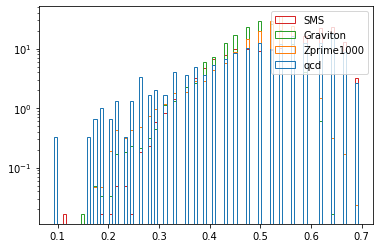

In [121]:
plt.style.use(hep.style.CMS)
_ = plt.hist([loss_qcd.flatten(), *signal_losses], bins=100, label=['qcd']+list(signal_dict.keys()), histtype='step', density=True)
plt.yscale('log')
plt.legend()

In [94]:
print(min(loss_qcd), max(loss_qcd))

0.092593215 0.6932733


In [95]:
print(min(loss_signal), max(loss_signal))

0.21566184 0.6155965


In [118]:
len(signal_losses)

3

/eos/home-k/kiwoznia/dev/ada_hackaton_2021/scouting_fatjet_graph/data_analysis/plotting.py:80: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-k/kiwoznia/dev/ada_hackaton_2021/scouting_fatjet_graph/data_analysis/plotting.py:80: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-k/kiwoznia/dev/ada_hackaton_2021/scouting_fatjet_graph/data_analysis/plotting.py:80: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")


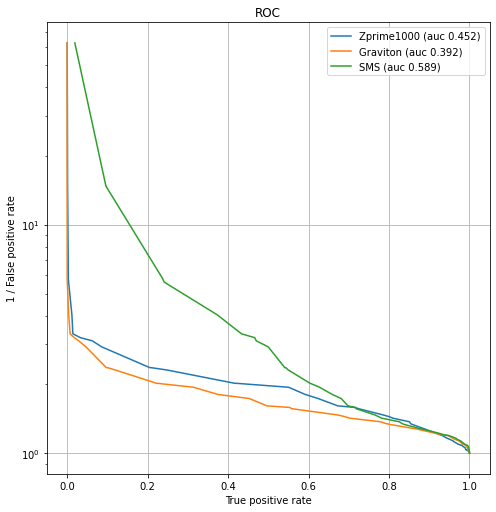

[0.45174485714285717, 0.3922179, 0.5888722]

In [122]:
plott.plot_roc([loss_qcd]*3, signal_losses, legend=list(signal_dict.keys()), log_x=False)